# dynamic gesture recognition using a CNN


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline 
#notebook

In [2]:
file_path_screwdriver_grasp = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schraubendreher\grasp_screwdriver.json"
file_path_screwdriver_release = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schraubendreher\release_screwdriver.json"
file_path_fist_grasp = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Faust\grasp_fist.json"
file_path_fist_release = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Faust\release_fist.json"
file_path_screw_grasp = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schrauben\grasp_screw.json"
file_path_screw_release = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schrauben\release_screw.json"
file_path_cordlessDrill_grasp = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Akkuschrauber\grasp_cordlessdrill.json"
file_path_cordlessDrill_release = r"C:\Users\DaniH\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Akkuschrauber\release_cordlessdrill.json"
file_path_list = [file_path_screwdriver_grasp,file_path_screwdriver_release,
                  file_path_fist_grasp,file_path_fist_release,
                  file_path_screw_grasp,file_path_screw_release,
                  file_path_cordlessDrill_grasp,file_path_cordlessDrill_release]

df_list = []
for ind,element in enumerate(file_path_list):
    df_list.append(pd.read_json(element))

file_path_screwdriver_grasp = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schraubendreher\grasp_screwdriver.json"
file_path_screwdriver_release = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schraubendreher\release_screwdriver.json"
file_path_fist_grasp = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Faust\grasp_fist.json"
file_path_fist_release = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Faust\release_fist.json"
file_path_screw_grasp = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schrauben\grasp_screw.json"
file_path_screw_release = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Schrauben\release_screw.json"
file_path_cordlessDrill_grasp = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Akkuschrauber\grasp_cordlessdrill.json"
file_path_cordlessDrill_release = r"C:\Users\Daniel\OneDrive\Bachelorarbeit\Daten\Datenaufnahme\Akkuschrauber\release_cordlessdrill.json"
file_path_list = [file_path_screwdriver_grasp,file_path_screwdriver_release,
                  file_path_fist_grasp,file_path_fist_release,
                  file_path_screw_grasp,file_path_screw_release,
                  file_path_cordlessDrill_grasp,file_path_cordlessDrill_release]

df_list = []
for ind,element in enumerate(file_path_list):
    df_list.append(pd.read_json(element))

In [3]:
description_list = []
for element in df_list:
    description_list.append(element["nameOfTask"].unique()[0])
description_list

['screwdriver_grasp',
 'screwdriver_release',
 'fist_grasp',
 'fist_release',
 'screw_grasp',
 'screw_release',
 'cordless drill grasp',
 'cordless drill release']

In [4]:
def func_df_preparation(df): 
    df.drop(["userName","typeOfRecording","nameOfTask"],axis=1,inplace=True) # überflüssige Spalten löschen
    df.sort_values(["timeStamp"],ignore_index=True,inplace=True) # nach timeStamp sortieren
    df.drop_duplicates(subset=["timeStamp"],keep="first",inplace=True,ignore_index=True) # Duplikate rauswerfen
    return df

In [5]:
unique_recordings = [] #[9,10,10,11] jeweils Anzahl der Aufnahmen
for ind,element in enumerate(df_list):
    df_list[ind] = func_df_preparation(element)
    unique_recordings.append(element["recordingNumber"].nunique())
    print("Number unique testing sequences {}:\t {}".format(description_list[ind],element["recordingNumber"].nunique()))

Number unique testing sequences screwdriver_grasp:	 9
Number unique testing sequences screwdriver_release:	 9
Number unique testing sequences fist_grasp:	 10
Number unique testing sequences fist_release:	 10
Number unique testing sequences screw_grasp:	 10
Number unique testing sequences screw_release:	 10
Number unique testing sequences cordless drill grasp:	 11
Number unique testing sequences cordless drill release:	 11


In [6]:
def func_rel_column_names(only_right=True):
    rel_cols = []
    if only_right:
        for k in range(6):
            for col in df_list[0].columns[:-3]:
                rel_cols.append(col+str(8+k)+"_rel")  
    else:
        for k in range(6):
            for col in df_list[0].columns[:-3]:
                rel_cols.append(col+str(1+k)+"_rel") 
    return(rel_cols)

In [7]:
only_right_hand = True
rel_cols_right = func_rel_column_names(only_right_hand)
rel_cols_angle = [ x for x in rel_cols_right if "acc" not in x ]
rel_cols_acc = [ x for x in rel_cols_right if "acc" in x ]

In [8]:
def func_df_rel(df_in,label):
    df1 = pd.DataFrame(df_in[df_in.columns[-3:]])
    arr = np.zeros((df_in.shape[0],36))
    for ind,row in df_in.iterrows():
        for sensor in range(6):
            for dim in range(6):
                arr[ind,sensor*6+dim] = df_in.iloc[ind,dim][sensor+8]-df_in.iloc[ind,dim][7]
    df2 = pd.DataFrame(arr,columns=rel_cols_right)
    df2["label"] = label
    return pd.concat([df1,df2],axis=1)

In [9]:
start_time = time.time()

df_data_right_rel = []
for ind,element in enumerate(df_list):
    df_data_right_rel.append(func_df_rel(element.copy(),ind))
df_data_right_rel[0]

print(time.time()-start_time)

18.598857164382935


In [10]:
len(df_data_right_rel)

8

In [11]:
ele = df_data_right_rel[0]
temp_df = ele[ele["recordingNumber"]==0+1].copy()
temp_arr = temp_df[rel_cols_angle].values
temp_arr.shape

(121, 18)

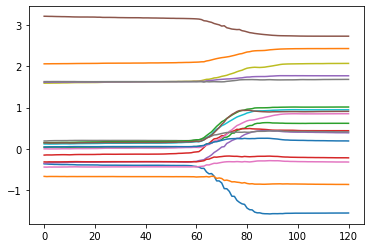

In [12]:
plt.plot(temp_arr)
plt.show()

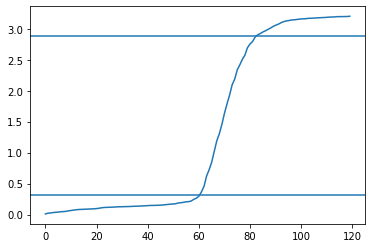

In [13]:
plt.plot(np.cumsum(np.linalg.norm(np.diff(temp_arr,axis=0),axis=1)))
plt.axhline(0.1*np.sum(np.linalg.norm(np.diff(temp_arr,axis=0),axis=1)))
plt.axhline(0.9*np.sum(np.linalg.norm(np.diff(temp_arr,axis=0),axis=1)))
plt.show()

In [14]:
def func_gps(df_data_right_rel_ele):
    
    start_ind = np.zeros(ele["recordingNumber"].nunique())
    end_ind = np.zeros(ele["recordingNumber"].nunique())
    
    for sample in range(df_data_right_rel_ele["recordingNumber"].nunique()):
        temp_df = df_data_right_rel_ele[df_data_right_rel_ele["recordingNumber"]==sample+1].copy()
        temp_arr = temp_df[rel_cols_angle].values

        a = np.cumsum(np.linalg.norm(np.diff(temp_arr,axis=0),axis=1))
        b = np.sum(np.linalg.norm(np.diff(temp_arr,axis=0),axis=1))
        start_ind[sample] = int(np.where(a/b<0.10)[0][-1])
        end_ind[sample] = int(np.where(a/b<0.90)[0][-1])

    gesture_length_arr = end_ind - start_ind 
    
    return(start_ind,end_ind,gesture_length_arr)   

In [15]:
start_ind_list = []
end_ind_list = []
gesture_length_list = []


for ele in df_data_right_rel:
    start,end,length = func_gps(ele)
    
    start_ind_list.append(start)
    end_ind_list.append(end)
    gesture_length_list.append(length)

In [16]:
flatten_list = pd.core.common.flatten(gesture_length_list)
min_length = np.min(np.array(list(flatten_list),dtype=int))
min_length

9

In [17]:
min_length

9

In [18]:
df_gps_cutted = []

for ind,ele in enumerate(df_data_right_rel):
    for sample in range(ele["recordingNumber"].nunique()):
        ele0 = ele[ele["recordingNumber"]==sample+1].copy()
        ele0.reset_index(drop=True,inplace=True)
        temp_df = ele0.loc[start_ind_list[ind][sample] : end_ind_list[ind][sample]]
        temp_df["label"] = ind
        df_gps_cutted.append(temp_df.reset_index(drop=True))

In [19]:
len(df_gps_cutted)

80

In [20]:
def func_moving_window(df_in,steps=2):
    df = df_in.copy()
    df_len = df.shape[0]
    sub_df_list = []
    if df_len % steps == 0:
        for i in range(df_len//steps):
            sub_df_list.append(df.loc[i*steps : (i+1)*steps-1])
    else:
        for i in range(df_len//steps):
            sub_df_list.append(df.loc[i*steps : (i+1)*steps-1])
        sub_df_list.append(df.loc[df_len-steps : ])
    return sub_df_list

In [21]:
df_gps_windowed = []
for ind, ele in enumerate(df_gps_cutted):
    for sublist in func_moving_window(ele,min_length):
        sublist.reset_index(drop=True,inplace=True)
        df_gps_windowed.append(sublist)
len(df_gps_windowed)

203

In [22]:
df_gps_windowed[202][rel_cols_angle].shape

(9, 18)

In [23]:
n_samples = len(df_gps_windowed)
n_timeSteps = df_gps_windowed[0][rel_cols_angle].shape[0]
n_features = df_gps_windowed[0][rel_cols_angle].shape[1]

X_arr = np.zeros((n_samples,n_timeSteps,n_features))
y_arr = np.zeros(n_samples)

for ind,ele in enumerate(df_gps_windowed):
    X_arr[ind,:,:] = ele[rel_cols_angle].values
    y_arr[ind] = ele["label"].loc[0]

X_arr.shape,y_arr.shape

((203, 9, 18), (203,))

X_list = []
y_list = []
for ind,ele in enumerate(df_data_right_rel):
    
    n_samples = ele["recordingNumber"].nunique()
    n_timeSteps = 25
    n_features = len(rel_cols_right)
    
    X_list.append(np.zeros((n_samples,n_timeSteps,n_features)))
    
    for sample in range(n_samples):
        y_list.append(ind)
        temp_df = ele[ele["recordingNumber"]==sample+1].copy()
        temp_arr = temp_df[rel_cols_right].values
        start_value = 40
        for timeStamp in range(n_timeSteps):
            for feature in range(n_features):
                X_list[-1][sample,timeStamp,feature] = temp_arr[start_value+timeStamp,feature]
X_list[1].shape

gesture = np.random.randint(len(X_list))
print(f"gesture: {description_list[gesture]}")
recordingNum = 1
sensorNum = 0

fig,ax = plt.subplots(X_list[recordingNum].shape[0],figsize=(10,20))
for ind,temp_ax in enumerate(ax):
    temp_ax.plot(X_list[gesture][ind,:,sensorNum:sensorNum+3])
    temp_ax.set_ylabel(ind)
plt.show

In [24]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

y = np.array(y_list)
#print(y)
X = np.concatenate(X_list)
X.shape  

In [25]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_arr, y_arr,test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(162, 9, 18) (162,) (41, 9, 18) (41,)


In [26]:
a = tf.keras.utils.normalize(X_train, axis=-1, order=2)
a.shape

(162, 9, 18)

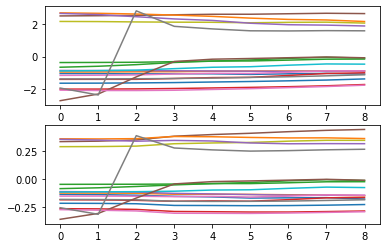

In [27]:
fig,ax = plt.subplots(2)
ax[0].plot(X_train[0])
ax[1].plot(a[0])
plt.show()

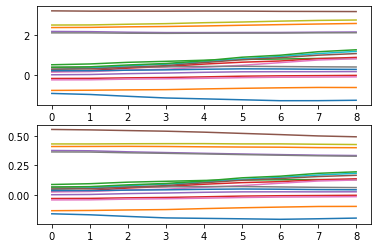

In [28]:
fig,ax = plt.subplots(2)
ax[0].plot(X_train[5])
ax[1].plot(a[5])
plt.show()

In [29]:
x_flatten_train = X_train.reshape((X_train.shape[0]*X_train.shape[1],X_train.shape[2]))
x_flatten_test = X_test.reshape((X_test.shape[0]*X_test.shape[1],X_test.shape[2]))
x_flatten_train.shape

(1458, 18)

In [30]:
scaler = np.max(abs(X_train))
scaler

4.3894632055

In [31]:
X_train_norm = X_train/scaler
X_test_norm = X_test/scaler

from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler().fit(x_flatten_train)
X_train_norm = Scaler.transform(x_flatten_train).reshape(X_train.shape)
X_test_norm = Scaler.transform(x_flatten_test).reshape(X_test.shape)

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [33]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [34]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_timesteps, n_features, n_outputs

(9, 18, 8)

In [45]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


fitted = model.fit(X_train_norm, y_train, epochs=50, batch_size=1, verbose=0)#,validation_split=0.2)

loss, acc = model.evaluate(X_test_norm, y_test, verbose=0)
acc

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 7, 64)             3520      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 5, 32)             6176      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                

1.0

In [51]:
model.save("CNN_model_64_32_50_1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN_model_64_32_50_1\assets


In [53]:
a = tf.keras.models.load_model("CNN_model_64_32_50_1")
a.evaluate(X_test_norm, y_test, verbose=0)

[0.04768197610974312, 1.0]

In [46]:
y_test

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

In [47]:
y_pred = np.round(model.predict(X_test),2)
y_pred

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.9 , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.07, 0.  , 0.  , 0.93, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ,

In [48]:
np.argmax(y_pred,axis=1)

array([0, 0, 4, 3, 2, 1, 6, 7, 7, 7, 2, 6, 6, 7, 2, 7, 0, 3, 2, 6, 7, 3,
       3, 1, 5, 0, 6, 3, 6, 5, 2, 2, 5, 2, 3, 4, 5, 5, 6, 3, 3],
      dtype=int64)

In [49]:
y_test_neu = np.argmax(y_test,axis=1)
y_pred_neu = np.argmax(y_pred,axis=1)

In [50]:
from sklearn.metrics import confusion_matrix 

confusion_matrix(y_test_neu,y_pred_neu)

array([[4, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 7, 0, 0, 0, 0, 0],
       [0, 0, 0, 8, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 7, 0],
       [0, 0, 0, 0, 0, 0, 0, 6]], dtype=int64)